In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

import mne

In [2]:
alice_files = ["/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/2d42885b-ba49-4c21-9e8f-4963349f252c/Traces.edf",
               "/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/2d42885b-ba49-4c21-9e8f-4963349f252c/Traces_annotations.edf"]
bob_files = ["/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/4f680835-27cb-422f-b254-1d2994ff548a/Traces.edf",
             "/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/4f680835-27cb-422f-b254-1d2994ff548a/Traces_annotations.edf"]

raw_train_alice = mne.io.read_raw_edf(
    alice_files[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error",  # ignore issues with stored filter settings
)
annot_train_alice = mne.read_annotations(alice_files[1])

In [21]:
raw_train_alice.set_annotations(annot_train_alice, emit_warning=False)
print()

Using matplotlib as 2D backend.


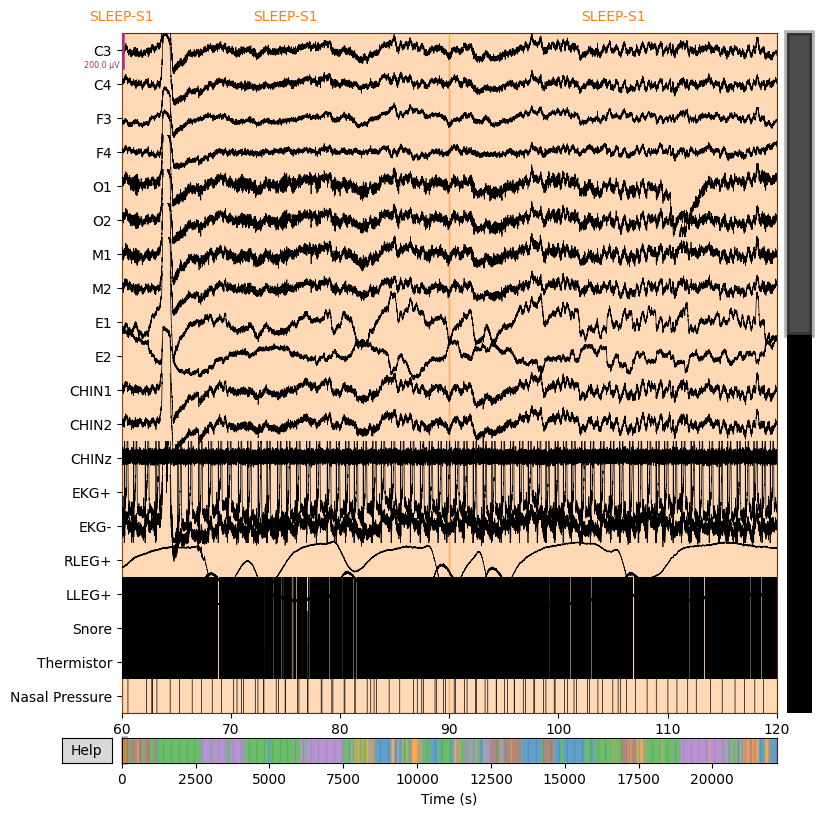

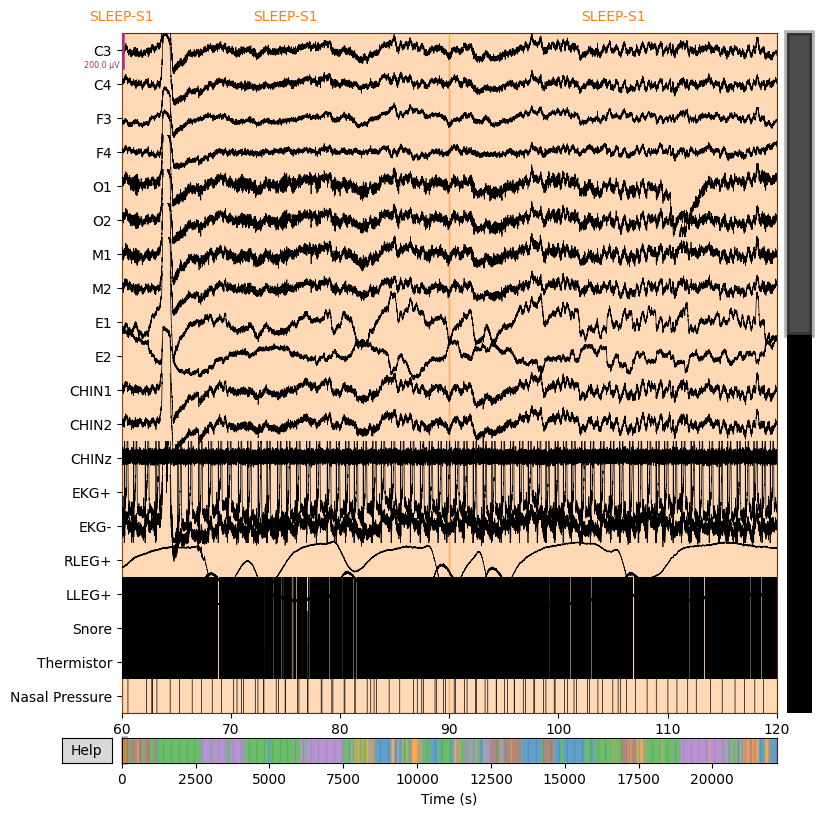

In [4]:
# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train_alice.plot(
    start=60,
    duration=60,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
)

In [5]:
alice_files[0]

'/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/2d42885b-ba49-4c21-9e8f-4963349f252c/Traces.edf'

In [6]:
alice_files[1]

'/home/user/sleep-stage/rmlogic_data/data/REMLOGIC HASTA VERİLERİ/2d42885b-ba49-4c21-9e8f-4963349f252c/Traces_annotations.edf'

Used Annotations descriptions: [np.str_('SLEEP-REM'), np.str_('SLEEP-S1'), np.str_('SLEEP-S2'), np.str_('SLEEP-S3'), np.str_('SLEEP-W')]


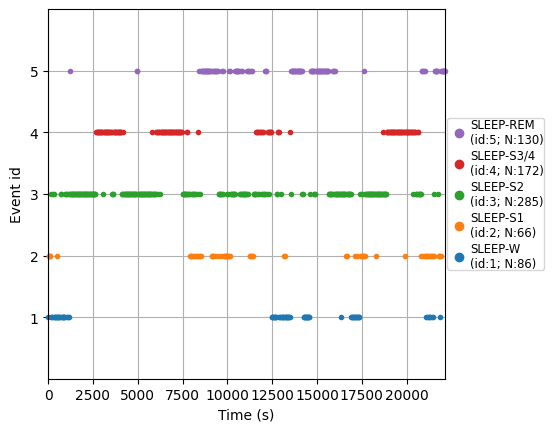

In [7]:
annotation_desc_2_event_id = {
    "SLEEP-W": 1,
    "SLEEP-S1": 2,
    "SLEEP-S2": 3,
    "SLEEP-S3": 4,
    "SLEEP-S4": 4,
    "SLEEP-REM": 5,
}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train_alice.crop(annot_train_alice[1]["onset"] - 30 * 60, annot_train_alice[-2]["onset"] + 30 * 60)
raw_train_alice.set_annotations(annot_train_alice, emit_warning=False)

events_train_alice, _ = mne.events_from_annotations(
    raw_train_alice, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

# create a new event_id that unifies stages 3 and 4
event_id = {
    "SLEEP-W": 1,
    "SLEEP-S1": 2,
    "SLEEP-S2": 3,
    "SLEEP-S3/4": 4,
    "SLEEP-REM": 5,
}

# plot events
fig = mne.viz.plot_events(
    events_train_alice,
    event_id=event_id,
    sfreq=raw_train_alice.info["sfreq"],
    first_samp=events_train_alice[0, 0],
)

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [8]:
tmax = 30.0 - 1.0 / raw_train_alice.info["sfreq"]  # tmax in included

epochs_train_alice = mne.Epochs(
    raw=raw_train_alice,
    events=events_train_alice,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)

print(epochs_train_alice)

Not setting metadata
739 matching events found
No baseline correction applied
0 projection items activated
<Epochs | 739 events (good & bad), 0 – 29.996 s (baseline off), ~47 KiB, data not loaded,
 'SLEEP-W': 86
 'SLEEP-S1': 66
 'SLEEP-S2': 285
 'SLEEP-S3/4': 172
 'SLEEP-REM': 130>


In [9]:
raw_test_bob = mne.io.read_raw_edf(
    bob_files[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error",
)

In [10]:
annot_test_bob = mne.read_annotations(bob_files[1])
annot_test_bob.crop(annot_test_bob[1]["onset"] - 30 * 60, annot_test_bob[-2]["onset"] + 30 * 60)

<Annotations | 707 segments: SLEEP-REM (107), SLEEP-S1 (119), SLEEP-S2 ...>

In [11]:
raw_test_bob.set_annotations(annot_test_bob, emit_warning=False)
raw_test_bob.annotations

<Annotations | 707 segments: SLEEP-REM (107), SLEEP-S1 (119), SLEEP-S2 ...>

In [12]:
events_test_bob, _ = mne.events_from_annotations(
    raw_test_bob, event_id=annotation_desc_2_event_id, chunk_duration=30.0
)

Used Annotations descriptions: [np.str_('SLEEP-REM'), np.str_('SLEEP-S1'), np.str_('SLEEP-S2'), np.str_('SLEEP-S3'), np.str_('SLEEP-W')]


In [13]:
epochs_test_bob = mne.Epochs(
    raw=raw_test_bob,
    events=events_test_bob,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)

Not setting metadata
706 matching events found
No baseline correction applied
0 projection items activated


In [14]:
print(epochs_test_bob)

<Epochs | 706 events (good & bad), 0 – 29.996 s (baseline off), ~47 KiB, data not loaded,
 'SLEEP-W': 100
 'SLEEP-S1': 119
 'SLEEP-S2': 256
 'SLEEP-S3/4': 124
 'SLEEP-REM': 107>


In [15]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [16]:
pipe_adaboost = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train_alice = epochs_train_alice.events[:, 2]
pipe_adaboost.fit(epochs_train_alice, y_train_alice)

# Test
y_pred_bob = pipe_adaboost.predict(epochs_test_bob)

# Assess the results
y_test_bob = epochs_test_bob.events[:, 2]
acc = accuracy_score(y_test_bob, y_pred_bob)

print(f"Accuracy score: {acc}")

Using data from preloaded Raw for 739 events and 7680 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_3015554/1837359462.py:27: UserWarning: Zero value in spectrum for channel Flattening
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
/tmp/ipykernel_3015554/1837359462.py:30: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)


Using data from preloaded Raw for 706 events and 7680 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_3015554/1837359462.py:27: UserWarning: Zero value in spectrum for channel Flattening
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
/tmp/ipykernel_3015554/1837359462.py:30: RuntimeWarning: invalid value encountered in divide
  psds /= np.sum(psds, axis=-1, keepdims=True)


Accuracy score: 0.471671388101983


In [17]:
print(confusion_matrix(y_test_bob, y_pred_bob))

[[ 44   0  44   7   5]
 [ 23   0  82   0  14]
 [  5   0 248   0   3]
 [  0   0 100  24   0]
 [ 18   0  72   0  17]]


In [18]:
print(classification_report(y_test_bob, y_pred_bob, target_names=event_id.keys()))

              precision    recall  f1-score   support

     SLEEP-W       0.49      0.44      0.46       100
    SLEEP-S1       0.00      0.00      0.00       119
    SLEEP-S2       0.45      0.97      0.62       256
  SLEEP-S3/4       0.77      0.19      0.31       124
   SLEEP-REM       0.44      0.16      0.23       107

    accuracy                           0.47       706
   macro avg       0.43      0.35      0.32       706
weighted avg       0.44      0.47      0.38       706



/home/user/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from lazypredict.Supervised import LazyClassifier

# Alice'in eğitim verisini ve Bob'un test verisini kullan
# EEG verisini uygun forma getiriyoruz.
X_train = epochs_train_alice.get_data().reshape(len(epochs_train_alice), -1)  # Alice train
y_train = y_train_alice

# Bob'un test verisini uygun forma getiriyoruz.
X_test = epochs_test_bob.get_data().reshape(len(epochs_test_bob), -1)  # Bob test
y_test = y_test_bob

# LazyClassifier ile tüm modelleri test et
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# Alice ile eğitip Bob üzerinde test ediyoruz.
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)
